# CO2 calculation bottom up method
### - From power plant data to country aggregated CO2 intensity of electricity generation -

In this script we calculated an CO2 emission factor per country out of hourly power plant generation and yearly published emission data on plant level.

The used method follows the idea to calculated a CI for specific power plants. In a second step an representative sample of power plants for a country is build and an CI for each technology and country is calculated.

# Script setup

In [2]:
import os
import logging

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from IPython.display import Image 

%matplotlib inline
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [15, 10]

#helpers
def change_ProductionTypeName (ProductionTypeName):
    return ProductionTypeName.replace(
                    {
            'Fossil Hard coal': 'hard_coal', 
            'Fossil Brown coal/Lignite': 'lignite', 
            'Fossil Gas': 'gas', 
            'Fossil Oil': 'other_fossil',
            'Fossil Coal-derived gas': 'other_fossil',
            'Fossil Peat': 'other_fossil',
            'Fossil Oil Shale': 'other_fossil',
            'Nuclear': 'nuclear',
            'Biomass': 'biomass',
            'Waste': 'waste',
            'Geothermal': 'geothermal',
            'Marine': 'marine',
            'Other': 'other_fossil',
            'Hydro Pumped Storage': 'hydro',
            'Hydro Run-of-river and poundage': 'hydro',
            'Hydro Water Reservoir': 'hydro',
            'Fossil Oil': 'oil',
            'Fossil Oil shale': 'oil', 
            'Solar': 'solar',
            'Wind Onshore': 'wind_onshore',
            'Wind Offshore': 'wind_offshore',
            'Other renewable': 'other_renewable',
                                 }, regex = True, inplace = False)

# Data directory preparention

Create input, processed and output folders if they don't exist
If the paths are relative, the corresponding folders will be created inside the current working directory.

In [3]:
input_directory_path = os.path.join('input')
Bootom_up_methode_input_directory_path = os.path.join('input', 'Bootom_up_methode')
processed_directory_path = 'processed'
output_directory_path = os.path.join('output')

os.makedirs(input_directory_path, exist_ok=True)
os.makedirs(Bootom_up_methode_input_directory_path, exist_ok=True)
os.makedirs(processed_directory_path, exist_ok=True)
os.makedirs(output_directory_path, exist_ok=True)

# Data file preperation

The directory `input/Bootom_up_method` should contain all necessary raw data files.

Based on the developed method the following data sets needed:

1) Matcher for power plants in Entso e and EUTL Data for Europe
The matching was performed by a manual process (see description).

File - > Matching_Entso_EUTL_EU.csv

2) EU Emissions Data (EUTL)
Data are provided in the report section. See the following link:
https://ec.europa.eu/clima/policies/ets/registry_en#tab-0-1

For example: ->Documentation->Reports->Verified Emissions for 2019

File - > "Verified Emissions for 2019" -> verified_emissions_2018_en.xlsx -> converted to .csv

Another way to check the data is directly through the European Union Transaction Log:
https://ec.europa.eu/clima/ets/napMgt.do?languageCode=en

3) ENTSO-E production per unit 
Production per Unit from ENTSO-E
Original data: ENTSO-E Transparency Platform, Actual Generation per Generation Unit Available online: https://transparency.entsoe.eu/generation/r2/actualGenerationPerGenerationUnit/show (accessed on Apr 29, 2020).
Processed with the following script that converts the data to hourly resolution (private script from INATECH):
https://github.com/INATECH-CIG/entso-e_GenerationOutputPerUnit


File - > gen_data.csv -> hourly generation data per unit\

File - > unit_data.csv -> information about the generation units

4) ENTSO-E production per type
Production per Unit from ENTSO-E
Original data: ENTSO-E Transparency Platform, Actual Generation per Production Type Available online: 
https://transparency.entsoe.eu/generation/r2/actualGenerationPerProductionType/show
Processed with the following script that converts the data to hourly resolution (private script from INATECH):
.... need to be updated ....
 File - > 


In [4]:
# Checks if the the input directories are empty or not
# Checks all filenames in the input directory

if not os.listdir(Bootom_up_methode_input_directory_path) :
    print("The directory for the bootom up method is empty. Please provide the data to the directory as described in the instructions above.")


filenames = [os.path.join(Bootom_up_methode_input_directory_path, fn) for fn in os.listdir(Bootom_up_methode_input_directory_path)]

print(filenames)

['input\\Bootom_up_methode\\entsoe_unit_gen_data.csv', 'input\\Bootom_up_methode\\gen_data.csv', 'input\\Bootom_up_methode\\Matching_Entso_EUTL_EU.csv', 'input\\Bootom_up_methode\\Matching_Entso_EUTL_EU_2.csv', 'input\\Bootom_up_methode\\Matching_Entso_EUTL_LCPD.csv', 'input\\Bootom_up_methode\\nrg_cb_pem.csv', 'input\\Bootom_up_methode\\time_series_60min_multiindex.csv', 'input\\Bootom_up_methode\\unit_data.csv', 'input\\Bootom_up_methode\\verified_emissions_2018_en.csv', 'input\\Bootom_up_methode\\verified_emissions_2018_en.xlsx']


# Load data functions

In [5]:
def load_matching_data_EU(path, fn):
    """
    Matching List for EU power plants with Entso e identifier and the EUTL identifier.
        
    Parameters
    ----------
    path: str
        path to data
    fn : str
        filename
        
    """
    
    logging.info(f'Loading data from {fn}')
    
    df = pd.read_csv(os.path.join(path, fn), sep = ',', header = 0, index_col=0)

    return df

def load_EUTL_data(path, fn):
    """
    EU Emissions Data (EUTL)
        
    Parameters
    ----------
    path: str
        path to data
    fn : str
        filename
        
    """
    
    logging.info(f'Loading data from {fn}')
    
    df = pd.read_csv(os.path.join(path, fn),sep = ';',header = 13,encoding ='unicode_escape' )

    return df

def load_generation_data(path, fn):
    """
    Entso e gernation data per unit
        
    Parameters
    ----------
    path: str
        path to data
    fn : str
        filename
        
    """
    
    logging.info(f'Loading data from {fn}')
    
    df = pd.read_csv(os.path.join(path, fn),sep = ',',index_col=0,parse_dates=True)
    

    return df

def load_unit_data(path, fn):
    """
    Entso e generation unit information
        
    Parameters
    ----------
    path: str
        path to data
    fn : str
        filename
        
    """
    
    logging.info(f'Loading data from {fn}')
    
    df = pd.read_csv(os.path.join(path, fn),sep = ',',index_col=0)
    
    # Rename production type name according to own convention
    df.ProductionTypeName = change_ProductionTypeName(df.ProductionTypeName)
    
    # set name for the index
    df.index.set_names('GenerationUnitEIC', inplace=True)

    return df

def load_timeseries_opsd(path, fn):
    """
    Read data from OPSD time-series package own modification.

    
    """
    generation = (pd.read_csv(os.path.join(path, fn), index_col=[0], header=[0, 1, 2, 3, 4, 5], parse_dates=True)
                    .dropna(how="all", axis=0))
        
  
    
    generation = generation.rename(columns={'GB_UKM' : 'GB'})
       
    
    return generation



# Load data sets

### Load power plant generation data.

In [6]:
generation_per_unit = load_generation_data(Bootom_up_methode_input_directory_path, 'gen_data.csv')

### Load power plant unit inforamtion (capacity, name, etc.)

In [7]:
generation_unit_info = load_unit_data(Bootom_up_methode_input_directory_path, 'unit_data.csv')

### Load CO2_emissions data from EUTL dataset

In [8]:
EUTL_emissions = load_EUTL_data(Bootom_up_methode_input_directory_path, 'verified_emissions_2018_en.csv')

### Load machting information for power plant data

In [9]:
unit_matching_EU = load_matching_data_EU(Bootom_up_methode_input_directory_path, 'Matching_Entso_EUTL_EU.csv')

# Method

## Yearly power generation per unit

Store the yearly generation per power plant to the power plant information data set.

In [10]:
generation_unit_info['yearly_generation_2018'] = generation_per_unit.sum()

## Matching ENTSO-E ID and EUTL ID

Combining matching information (ENTSO-E ID and EUTL ID) to the generation unit info

In [11]:
generation_unit_info_matched = pd.merge(generation_unit_info, unit_matching_EU, on='PowerSystemResourceName', how='inner')

## Function for connecting emissions and production data

In [12]:
def connect_CO2(df, ETS):
    # caring for characteristics of the dataset: EUTL-ID IS NOT UNIQUE - only countrywise.
    # removing power plants from the dataset which are not covered in ETS:
    miss_country = []
    for i in set(df.countrycode):
        if sum(i == ETS['REGISTRY_CODE']) == 0:
            print(i)
            miss_country.append(i)
            #removing this power plants from the list:
    df = df.query('countrycode not in @miss_country')
    
    # removing power plants where match could not be found:
    miss_match = []
    for j in df.PowerSystemResourceName:
        row = df[df.PowerSystemResourceName == j]
        if len(ETS.query('REGISTRY_CODE == @row.countrycode.iloc[0]')\
                  .query('INSTALLATION_IDENTIFIER == @row.EUTL_ID.iloc[0]')) == 0:
            print(j)
            miss_match.append(j)
            
    df = df.query('PowerSystemResourceName not in @miss_match')
    # apply matching:
    df['verified_emissions_18'] = df.apply(lambda x: ETS.query('REGISTRY_CODE==@x.countrycode')\
                                    .query('INSTALLATION_IDENTIFIER==@x.EUTL_ID')['VERIFIED_EMISSIONS_2018']\
                                    .iloc[0], axis = 1)
    df['verified_emissions_17'] = df.apply(lambda x: ETS.query('REGISTRY_CODE==@x.countrycode')\
                                    .query('INSTALLATION_IDENTIFIER==@x.EUTL_ID')['VERIFIED_EMISSIONS_2017']\
                                    .iloc[0], axis = 1)
    df['verified_emissions_16'] = df.apply(lambda x: ETS.query('REGISTRY_CODE==@x.countrycode')\
                                    .query('INSTALLATION_IDENTIFIER==@x.EUTL_ID')['VERIFIED_EMISSIONS_2016']\
                                    .iloc[0], axis = 1)
    df['verified_emissions_15'] = df.apply(lambda x: ETS.query('REGISTRY_CODE==@x.countrycode')\
                                    .query('INSTALLATION_IDENTIFIER==@x.EUTL_ID')['VERIFIED_EMISSIONS_2015']\
                                    .iloc[0], axis = 1)
    
    df['ETS_name'] = df.apply(lambda x: ETS.query('REGISTRY_CODE==@x.countrycode')\
                                    .query('INSTALLATION_IDENTIFIER==@x.EUTL_ID')['IDENTIFIER_IN_REG']\
                                    .iloc[0], axis = 1)
    return df

In [13]:
generation_unit_info_matched = connect_CO2(generation_unit_info_matched, EUTL_emissions)

Show first 10 entries from data

In [14]:
generation_unit_info_matched.head(10)

,AreaCode,AreaName,AreaTypeCode,InstalledGenCapacity,MapCode,PowerSystemResourceName,ProductionTypeName,duplicate_count,yearly_generation_2018,countrycode,EUTL_ID,verified_emissions_18,verified_emissions_17,verified_emissions_16,verified_emissions_15,ETS_name
0,10YAT-APG------L,APG CA,CTA,140.0,AT,Lau GuD,gas,2.0,0.00,AT,86.0,6300,3825,3136,4097,Wienstrom KW Leopoldau Wien
1,10YAT-APG------L,APG CA,CTA,400.0,AT,Kraftwerk Timelkam GUD,gas,2.0,685235.67,AT,149.0,267204,356994,213716,174692,Energie AG GuD Kraftwerk Timelkam
2,10YAT-APG------L,APG CA,CTA,332.0,AT,KW Dürnrohr Block 2,hard_coal,2.0,745290.41,AT,94.0,0,0,8,565110,Verbund KW Dürnrohr Zwentendorf
3,10YAT-APG------L,APG CA,CTA,150.0,AT,KW Riedersbach 2 G2,hard_coal,2.0,0.00,AT,79.0,6576,7775,203045,270681,KW Riedersbach
4,10Y1001A1001A796,Energinet CA,CTA,147.0,DK,Asnaesvaerket 2,hard_coal,1.0,219309.91,DK,48.0,878395,1048994,952588,695549,Asnæsværket
5,10Y1001A1001A796,Energinet CA,CTA,250.0,DK,Amagervaerket 3,hard_coal,1.0,1060165.23,DK,52.0,1038454,962853,1109048,862186,Amagerværket:DK299
6,10Y1001A1001A796,Energinet CA,CTA,377.0,DK,Esbjergvaerket 3,hard_coal,1.0,1193633.83,DK,80.0,1066679,767819,1212705,875783,Esbjergværket
7,10Y1001A1001A796,Energinet CA,CTA,372.0,DK,Fynsvaerket 7,hard_coal,1.0,770123.83,DK,69.0,747392,1053586,1155662,901683,Fjernvarme Fyn Produktion A/S Blok 7
8,10Y1001A1001A796,Energinet CA,CTA,108.2,DK,Silkeborgvaerket,gas,1.0,273443.11,DK,68.0,124943,80817,108179,35491,SKVV
9,10Y1001A1001A796,Energinet CA,CTA,640.0,DK,Asnaesvaerket 5,hard_coal,1.0,550708.39,DK,48.0,878395,1048994,952588,695549,Asnæsværket


## Carbon intensity (CI) per power plants (sites)

The following function calculates the CI for each entry in the EUTL data set. Due to the fact, that the EUTL data set has a spatial resolution on site level and not on power plant level it can happen, that power plants data need to be aggregated together in the emission calculation.

In [15]:
def calc_CI(df):
    # calculates the carbon intensity of sites. Due to non-unique labelings of the power plants across different
    # countries it needs care taken about it.
    
    df['verified_emissions_18']=df['verified_emissions_18'].apply(float)
    
    sites = pd.DataFrame(df.groupby(['countrycode','EUTL_ID']).mean()['verified_emissions_18']\
                       / df.groupby(['countrycode','EUTL_ID']).sum()['yearly_generation_2018'])\
                        .reset_index()
    df['carbon_intensity'] = df.apply(lambda x: sites.query('countrycode == @x.countrycode')\
                            .query('EUTL_ID == @x.EUTL_ID')[0].iloc[0],axis = 1)
    
    return df

In [16]:
generation_unit_info_matched = calc_CI(generation_unit_info_matched)

Show first 10 entries from data

In [17]:
generation_unit_info_matched.head()

,AreaCode,AreaName,AreaTypeCode,InstalledGenCapacity,MapCode,PowerSystemResourceName,ProductionTypeName,duplicate_count,yearly_generation_2018,countrycode,EUTL_ID,verified_emissions_18,verified_emissions_17,verified_emissions_16,verified_emissions_15,ETS_name,carbon_intensity
0,10YAT-APG------L,APG CA,CTA,140.0,AT,Lau GuD,gas,2.0,0.00,AT,86.0,6300.0,3825,3136,4097,Wienstrom KW Leopoldau Wien,inf
1,10YAT-APG------L,APG CA,CTA,400.0,AT,Kraftwerk Timelkam GUD,gas,2.0,685235.67,AT,149.0,267204.0,356994,213716,174692,Energie AG GuD Kraftwerk Timelkam,0.389945
2,10YAT-APG------L,APG CA,CTA,332.0,AT,KW Dürnrohr Block 2,hard_coal,2.0,745290.41,AT,94.0,0.0,0,8,565110,Verbund KW Dürnrohr Zwentendorf,0.000000
3,10YAT-APG------L,APG CA,CTA,150.0,AT,KW Riedersbach 2 G2,hard_coal,2.0,0.00,AT,79.0,6576.0,7775,203045,270681,KW Riedersbach,inf
4,10Y1001A1001A796,Energinet CA,CTA,147.0,DK,Asnaesvaerket 2,hard_coal,1.0,219309.91,DK,48.0,878395.0,1048994,952588,695549,Asnæsværket,1.140746


## Validation of carbon intensities (CI) per power plant

Check and test results and drop all results that are not plausible

In [18]:
# covert technologies for methode

tech = ['gas', 'hard_coal',
       'lignite', 'other_fossil']

Powerplants_emission_EU_CI = generation_unit_info_matched.query('ProductionTypeName in @tech').copy()

# not covert : 'Fossil Oil shale', 'Fossil Oil', 'Fossil Coal-derived gas','Fossil Peat'

Since not all emission factors are correctly calculated we limited the list of calculated emissions per power plant is checked by a plausibility check.

thresholds for plausibility check - until [g/kWh]: 
- lignite_high = 1750
- lignite_low = 800
-------------------
- hardcoal_high = 1350
- hardcoal_low = 700
-------------------
- gas_high = 550
- gas_low = 350
-------------------
- other_high = 1570
- other_low = 400

Numbers taken from:
https://www.gegenwind-saarland.de/Materialien/Energiewende/071031--VdI---CO2-Emissionen%20der%20Stromerzeugung_01.pdf

In [19]:
# emissions space per technology in [t CO2/MWh] 

emission_space = {"lignite": (1.750,.800),
                  "hard_coal": (1.350,.700),
                  "gas": (.550,.350),
                  "other_fossil": (1.570,.400)}


# Entwicklung der spezifischen Kohlendioxid-Emissionen des deutschen Strommix in den Jahren 1990 - 2018 (UBA)
# https://www.umweltbundesamt.de/sites/default/files/medien/1410/publikationen/2019-04-10_cc_10-2019_strommix_2019.pdf
#
# Unit: g CO2/kWh
#  
#lignite 1090,0
#coal 820
#gas 360
#other 1570 (Müll und Öl)
#
#
# um von t/MWh auf g/kWh zu kommen * 1000 

In [20]:
# function for CI check
def check_CI (row):
    if row.carbon_intensity > emission_space[row.ProductionTypeName][1] and row.carbon_intensity < emission_space[row.ProductionTypeName][0]:
        return True
    else:
        return False  

In [21]:
# us CI_check function for CI validation
Powerplants_emission_EU_CI['CI_validation'] = Powerplants_emission_EU_CI.apply(check_CI, axis=1)


In [26]:
# take only the data that are validated
Powerplants_emission_EU_CI_validated = Powerplants_emission_EU_CI[Powerplants_emission_EU_CI.CI_validation == True]

reasons why the CI is not valid:

1.) Match is not correct - then one more iteration is necessary

2.) Data is wrong or incomplete

3.) Match is correct, but it's a highly aggregated facility such like a steel manufacturing factory, where both process-CO2 AND the emissions from the power plant running the process accounts into the number given in the dataset.

4.) the facility contains more smaller power plants which are not covered by ENTSO-E (<100MW) but nevertheless
produce emissions which need to be paid for.

5.) if the number of the carbon-intensity is negative, then the dataset is explained as " -1 = blank (No allocation has been made / No Emissions have been Verified)"

In [46]:
Powerplants_emission_EU_CI_validated.columns

Index(['AreaCode', 'AreaName', 'AreaTypeCode', 'InstalledGenCapacity',
       'MapCode', 'PowerSystemResourceName', 'ProductionTypeName',
       'duplicate_count', 'yearly_generation_2018', 'countrycode', 'EUTL_ID',
       'verified_emissions_18', 'verified_emissions_17',
       'verified_emissions_16', 'verified_emissions_15', 'ETS_name',
       'carbon_intensity', 'CI_validation'],
      dtype='object')

Text(0, 0.5, 'Production technologie')

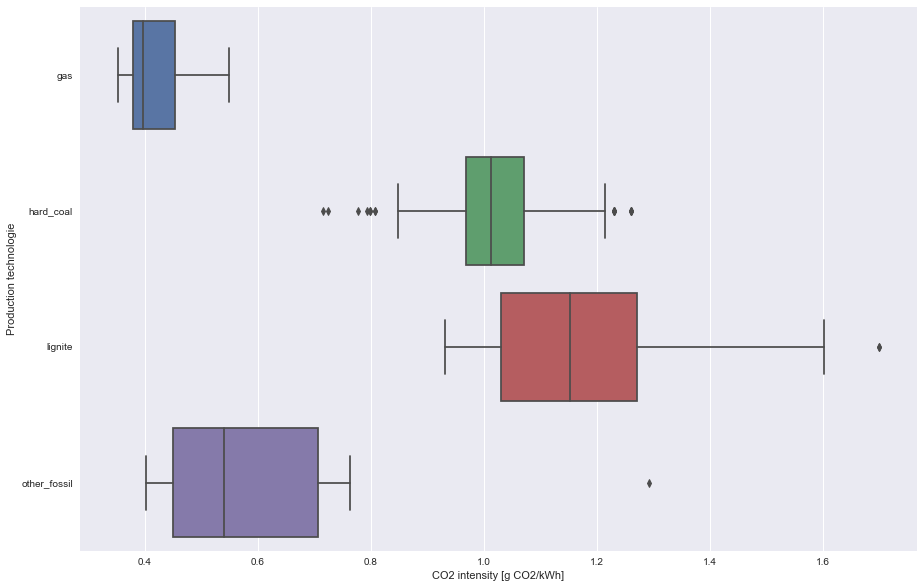

In [55]:
fig, ax = plt.subplots(1, 1)

ax = sns.boxplot(y="ProductionTypeName", x="carbon_intensity", data=Powerplants_emission_EU_CI_validated, orient="h")

ax.set_xlabel("CO2 intensity [g CO2/kWh]")
ax.set_ylabel("Production technologie")

In [57]:
fig.savefig(os.path.join(output_directory_path + '/_CO2_intensity_by_technology.png'))

## Mean carbon intensity per technology and country 

In [31]:
def calc_CI_tech_country(df):
    # calculates the average carbon intensity per technology in a country for plausible results defined above.
    # df is a dataframe which contains all sites with plausible carbon intensities of whole Europe.
    CI_tech_country = df.groupby(['countrycode','EUTL_ID','ProductionTypeName'])\
                                     .mean()['verified_emissions_18']\
                                     .groupby(['countrycode','ProductionTypeName']).sum()\
                                     /\
                      df.groupby(['countrycode','ProductionTypeName'])['yearly_generation_2018'].sum()
    return CI_tech_country

In [32]:
CI_PP_per_tech_country = calc_CI_tech_country(Powerplants_emission_EU_CI_validated)

In [33]:
# hier noch mal drüber sprechen. Wie sieht das aus, wenn die EUTL_ID zu einem Ort gehört, an dem zwei Kraftwerke mit unterschiedlicher Technologie stehen
# werte liegen leicht über den anderen Werten, da wir immer netto Strom nehmen und die anderen brutto Strom 

### Plot mean CI for countries and technologies 

<Figure size 1080x720 with 0 Axes>

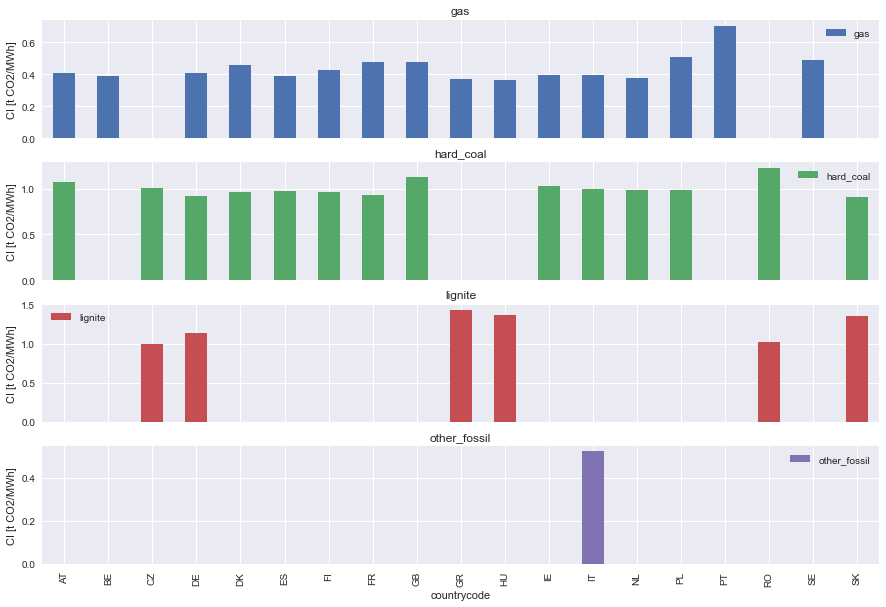

In [34]:
plt.figure()

CI_PP_per_tech_country.unstack(level=1).plot(kind='bar', subplots=True, ylabel='CI [t CO2/MWh]')

plt.grid(True)

### Check calculated CIs (are there represent the country production)

By comparing the used power plant production with the production per production type (from ENTSO-E) of each country, we can get an idea how trustful is our resulting CI.

In [59]:
entsoe_gen_type = load_timeseries_opsd(Bootom_up_methode_input_directory_path, 'time_series_60min_multiindex.csv')

Show the head of the data (the data is using a multi index for the columns)

In [60]:
entsoe_gen_type.head()

region                           cet_cest_timestamp  \
variable                         Unnamed: 1_level_1   
attribute                        Unnamed: 1_level_2   
source                           Unnamed: 1_level_3   
web                              Unnamed: 1_level_4   
unit                             Unnamed: 1_level_5   
utc_timestamp                                         
2018-01-01 00:00:00+00:00  2018-01-01T01:00:00+0100   
2018-01-01 01:00:00+00:00  2018-01-01T02:00:00+0100   
2018-01-01 02:00:00+00:00  2018-01-01T03:00:00+0100   
2018-01-01 03:00:00+00:00  2018-01-01T04:00:00+0100   
2018-01-01 04:00:00+00:00  2018-01-01T05:00:00+0100   

region                                                                                                     AT  \
variable                                                                                              biomass   
attribute                                                                                   generation_actual   
source                                                          own calculation based on ENTSO-E Transparency   
web                       https://transparency.entsoe.eu/generation/r2/actualGenerationPerProductionType/show   
unit                                                                                                       MW   
utc_timestamp                                                                                                   
2018-01-01 00:00:00+00:00                                              316.0                                    
2018-01-01 01:00:00+00:00                                              316.0                                    
2018-01-01 02:00:00+00:00                                              316.0                                    
2018-01-01 03:00:00+00:00                                              316.0                                    
2018-01-01 04:00:00+00:00                                              316.0                                    

region                                                                                                         \
variable                                                                                                  gas   
attribute                                                                                   generation_actual   
source                                                          own calculation based on ENTSO-E Transparency   
web                       https://transparency.entsoe.eu/generation/r2/actualGenerationPerProductionType/show   
unit                                                                                                       MW   
utc_timestamp                                                                                                   
2018-01-01 00:00:00+00:00                                               71.0                                    
2018-01-01 01:00:00+00:00                                               70.0                                    
2018-01-01 02:00:00+00:00                                               69.0                                    
2018-01-01 03:00:00+00:00                                               72.0                                    
2018-01-01 04:00:00+00:00                                               75.0                                    

region                                                                                                         \
variable                                                                                           geothermal   
attribute                                                                                   generation_actual   
source                                                          own calculation based on ENTSO-E Transparency   
web                       https://transparency.entsoe.eu/generation/r2/actualGenerationPerProductionType/show   
unit                                                        

Filter the data to the countries and technologies that are covert from our method
- countries

In [61]:
entsoe_gen_type = entsoe_gen_type[Powerplants_emission_EU_CI_validated.MapCode.unique()]

- technologies

In [62]:
entsoe_gen_type = entsoe_gen_type.loc[:,(slice(None),Powerplants_emission_EU_CI_validated.ProductionTypeName.unique())].sum()

Reset the multiindex from pandas and drop not used columns

In [63]:
entsoe_gen_type = entsoe_gen_type.reset_index()
entsoe_gen_type = entsoe_gen_type.drop(columns=['attribute', 'source', 'web', 'unit'])

Rename columns

In [64]:
entsoe_gen_type = entsoe_gen_type.rename(columns={0:'generation_per_type_2018_ENTSO-E','region':'MapCode','variable':'ProductionTypeName'})

Group production for each technology for the individual power plants

In [65]:
Powerplants_gen_type_year = pd.DataFrame(Powerplants_emission_EU_CI_validated.groupby(['MapCode','ProductionTypeName']).sum()['yearly_generation_2018'])

Reset the multiindex from pandas and drop not used columns

In [66]:
Powerplants_gen_type_year = Powerplants_gen_type_year.reset_index()

In [67]:
Powerplants_gen_type_year = Powerplants_gen_type_year.rename(columns={'yearly_generation_2018':'verified_generation_per_unit_2018_ENTSO-E'})

In [68]:
gen_data_comparison = entsoe_gen_type.merge(Powerplants_gen_type_year, on=['MapCode','ProductionTypeName'])

In [69]:
gen_data_comparison.head(10)

,MapCode,ProductionTypeName,generation_per_type_2018_ENTSO-E,verified_generation_per_unit_2018_ENTSO-E
0,AT,gas,8.168009e+06,3.895790e+06
1,AT,hard_coal,1.422450e+06,6.938571e+05
2,DK,gas,2.843756e+06,2.734431e+05
3,DK,hard_coal,6.426351e+06,5.161056e+06
4,BE,gas,2.230368e+07,1.096068e+07
5,DE,gas,4.295907e+07,1.318445e+07
6,DE,hard_coal,7.154638e+07,5.488206e+07
7,DE,lignite,1.283613e+08,1.292305e+08
8,FI,gas,5.000652e+06,1.969562e+06
9,FI,hard_coal,5.971642e+06,4.093411e+06


In [70]:
gen_data_comparison['missing_gen'] = gen_data_comparison['generation_per_type_2018_ENTSO-E'] - gen_data_comparison['verified_generation_per_unit_2018_ENTSO-E']

In [71]:
gen_data_comparison['gen_covered_pro'] = round((100 / gen_data_comparison['generation_per_type_2018_ENTSO-E']) * gen_data_comparison['verified_generation_per_unit_2018_ENTSO-E'])

covered generation per country and generation type

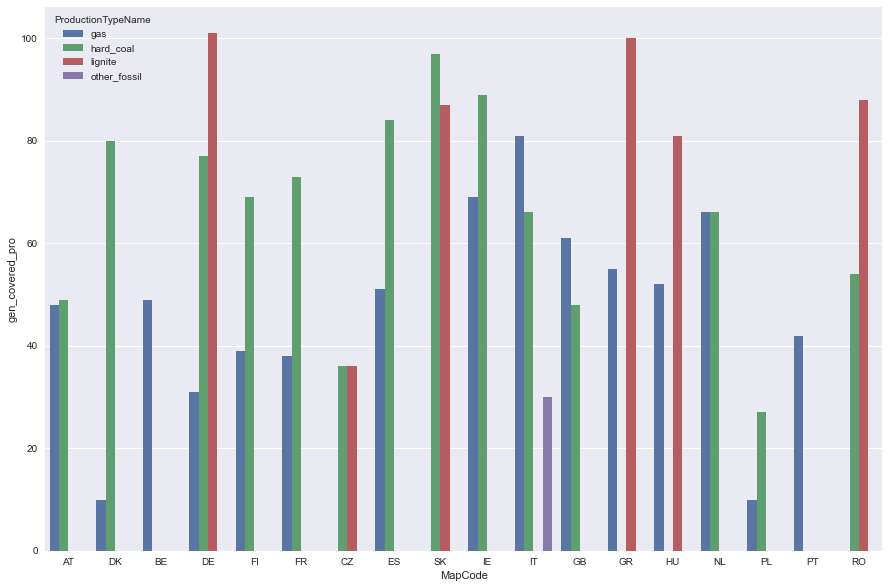

In [72]:
ax = sns.barplot(x="MapCode", y="gen_covered_pro", hue="ProductionTypeName", data=gen_data_comparison)

Mean coverage per country

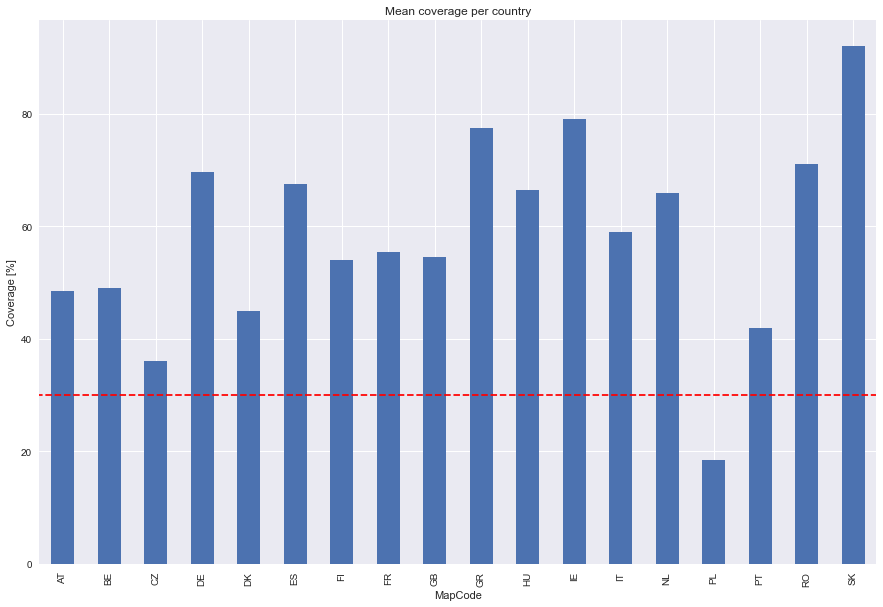

In [89]:
fig, ax = plt.subplots(1, 1)
ax = gen_data_comparison.groupby(['MapCode']).mean()['gen_covered_pro'].plot(kind='bar', title='Mean coverage per country', ylabel='Coverage [%]')
ax.plot([-10, 100], [30, 30], 'r--')

In [90]:
fig.savefig(os.path.join(output_directory_path + '/_mean_coverage_of_elec_production_per_country.png'))

Mean coverage over all countries

In [91]:
gen_data_comparison.gen_covered_pro.mean()

59.44444444444444

### Carbon intensity per technology and country

Take only the countries and technologies where at least 30 % of the generation is connected to CO2 emissions.

In [92]:
gen_data_comparison['Verified_for_CI_value'] = (round(gen_data_comparison['gen_covered_pro']) > 30)

In [93]:
gen_data_comparison.head(3)

,MapCode,ProductionTypeName,generation_per_type_2018_ENTSO-E,verified_generation_per_unit_2018_ENTSO-E,missing_gen,gen_covered_pro,Verified_for_CI_value
0,AT,gas,8168009.00,3895789.63,4272219.37,48.0,True
1,AT,hard_coal,1422450.00,693857.10,728592.90,49.0,True
2,DK,gas,2843755.58,273443.11,2570312.47,10.0,False


In [94]:
gen_data_comparison = gen_data_comparison.set_index(['MapCode','ProductionTypeName'])

In [95]:
CI_PP_per_tech_country = CI_PP_per_tech_country.reset_index().rename(columns={0:'CI','countrycode':'MapCode'}).set_index(['MapCode','ProductionTypeName'])

Transfer the verification of CI too the result

In [96]:
CI_PP_per_tech_country['Verified_CI_value'] = gen_data_comparison['Verified_for_CI_value']

export the CIs to csv

In [98]:
CI_PP_per_tech_country.to_csv(output_directory_path + '/CI_bottom_up_methode.csv')

# Carbon intensity for power generation 

In [ ]:
# Achtung, hier muss ich die ganze erzeugung nehmen nicht nur die tech spezifische 

In [104]:
entsoe_gen_type.set_index(['MapCode', 'ProductionTypeName'], inplace = True)

In [107]:
entsoe_gen_type['emissions'] = entsoe_gen_type['generation_per_type_2018_ENTSO-E'] * CI_PP_per_tech_country['CI']

In [114]:
entsoe_gen_type = entsoe_gen_type.reset_index()

,MapCode,ProductionTypeName,generation_per_type_2018_ENTSO-E,emissions
0,AT,gas,8.168009e+06,3.326398e+06
1,AT,hard_coal,1.422450e+06,1.521490e+06
2,AT,other_fossil,1.927200e+05,NaN
3,DK,gas,2.843756e+06,1.299383e+06
4,DK,hard_coal,6.426351e+06,6.167438e+06
5,BE,gas,2.230368e+07,8.715736e+06
6,BE,other_fossil,5.462483e+06,NaN
7,DE,gas,4.295907e+07,1.761256e+07
8,DE,hard_coal,7.154638e+07,6.586058e+07
9,DE,lignite,1.283613e+08,1.458345e+08


In [116]:
CI = entsoe_gen_type.groupby('MapCode').sum()['emissions'] / entsoe_gen_type.groupby('MapCode').sum()['generation_per_type_2018_ENTSO-E']

In [117]:
CI

MapCode
AT    0.495533
BE    0.313898
CZ    0.885738
DE    0.929391
DK    0.805473
ES    0.592241
FI    0.589732
FR    0.552594
GB    0.550265
GR    0.902675
HU    0.752055
IE    0.475408
IT    0.543840
NL    0.441957
PL    0.620924
PT    0.388345
RO    0.614206
SE    0.000000
SK    0.392222
dtype: float64

In [ ]:
CI_eea = pd.read_csv()

## Some other checks

Plausibility check for EF from power plants

In [24]:
# number of PP from matching
len(Powerplants_emission_EU_CI)

801

In [27]:
# validated PP with EF
len(Powerplants_emission_EU_CI_validated)

493

In [30]:
# covered generation by validated PP
Powerplants_emission_EU_CI_validated.yearly_generation_2018.sum()

589591944.6374995

In [44]:
# conv. generation in 2018
entsoe_gen_type['generation_per_type_2018_ENTSO-E'].sum()

1054364944.35

In [45]:
# in % of validated PP generation
(100 / (entsoe_gen_type['generation_per_type_2018_ENTSO-E'].sum())) * Powerplants_emission_EU_CI_validated.yearly_generation_2018.sum()

55.91915283194226

In [ ]:
coverage_val = len(Powerplants_emission_EU_CI) / len(generation_unit_info.query('ProductionTypeName in @tech'))
print("After validation we were able to allocate " + str(coverage_val*100) + " % of the power plants an emission value.")

In [ ]:
Powerplants_emission_EU_CI.yearly_generation_2018.sum()

coverage = len(Powerplants_emission_EU_CI) / len(generation_unit_info.query('ProductionTypeName in @tech'))
print("We were able to allocate " + str(coverage*100) + " % of the power plants an emission value.")

In [ ]:
# Plot CI per country for the technologies (drei Plots)

In [ ]:
Powerplants_emission_EU_CI.columns

In [ ]:
# Teste wie viel Energie decken wir mit dieser Methode ab?
# Dafür welche Daten verwenden (Problem Gross vs Net)
# Gibt es von Eurostat eine Net Version (ich glaube ja pro Monat)
# Dann Plot pro Land wie viel Dekcen wir ab (0 bis 1)



In [ ]:
# wie könnten wir ein representatives sample bilder. Das soll uns dann die CI ausrechnen

# Wie machen wir den Vergleich zur anderen Methode?

In [ ]:
# Jetzt können wir dann CI pro technologie bestimmen. 

vergleich unsere Jährliche Erzeugung mit denen, die wir von Ember bekommen haben (in 12, in Gfuellner Code) . Die unserscheidet sich. Was macht Ember noch mit den Daten?

In [ ]:
#generation_unit_info[generation_unit_info.PowerSystemResourceName == 'Scheldelaan Exxonmobil']

In [ ]:
pd.merge(generation_unit_info, unit_matching_EU, on='PowerSystemResourceName', how='left')

## Some check up numbers

In [ ]:
tech = ['Fossil Gas', 'Fossil Hard coal',
       'Fossil Brown coal/Lignite', 'Other']

print('number of pp in data set that has emissions that we want to match')
print(len(generation_unit_info.query('ProductionTypeName in @tech')))

print('generation in MWh in 2018 from the unis')
print(generation_unit_info.query('ProductionTypeName in @tech').yearly_generation_2018.sum())


(100/(generation_unit_info.query('ProductionTypeName in @tech').yearly_generation_2018.sum()))* Powerplants_emission_EU_CI.yearly_generation_2018.sum()

In [ ]:
generation_unit_info_matched[generation_unit_info_matched.ProductionTypeName == 'Other'].sort_values(by='yearly_generation_2018', ascending=False)

In [ ]:
generation_unit_info.ProductionTypeName.unique()

In [ ]:
# überprüfen, ob wir noch weitere technologien mit aufnehmen sollen 
# ich denke IT 'other' sollte man sich anschauen da haben wir auch schon einige drin.
tech = ['Fossil Oil shale', 'Fossil Oil','Fossil Coal-derived gas',
       'Fossil Peat', 'Other', 'Waste']

In [ ]:
generation_unit_info.query('ProductionTypeName in @tech').sort_values(by='yearly_generation_2018', ascending=False).head(50)

### --- Following function and data are only for check up the results and are not needed (test data)  --- 

1) Entso unit generation data from EMBER
The Entso e data has lot of gaps and need to be preprocessing (is done partly and the result is different than the one from Ember)

File - > entsoe_unit_gen_data.csv

In [ ]:
def load_unit_data_ember(path, fn):
    """
    Entso e unit generation from ember
        
    Parameters
    ----------
    path: str
        path to data
    fn : str
        filename
        
    """
    
    logging.info(f'Loading data from {fn}')
    
    df = pd.read_csv(os.path.join(path, fn), sep = ';', header = 0, encoding = 'unicode_escape')

    return df

# load the ember data
generation_per_unit_ember = load_unit_data_ember(Bootom_up_methode_input_directory_path, 'entsoe_unit_gen_data.csv') 

# filter to the year 2018
generation_per_unit_ember = generation_per_unit_ember[generation_per_unit_ember.Year == 2018]

# group and sum monthly data too yearly data
generation_per_unit_ember = generation_per_unit_ember.groupby(by = 'PowerSystemResourceName').sum()['Monthly Generation (GWh)']

In [ ]:
# for the ember datat the country code in germany needs to be converted 
def conv(x):
    # converts german grid operator areas string in german countrycode of ETS
    areas =['DE_TenneT_GER','DE_TransnetBW','DE_Amprion','DE_50HzT']
    if x in areas:
        x = 'DE' 
    return x

In [ ]:
#not needed anymore
#generation_per_unit_ember = generation_per_unit_ember.groupby(by = 'PowerSystemResourceName').agg({'Monthly Generation (GWh)': 'sum',
                                                                       'MapCode':'first',
                                                                       'ProductionTypeName':'first',
                                                                       
                                                                         'Year': 'first',
                                                                         'Installed Capacity (MW)': 'first'
                                                                      })
#merged_ember = pd.merge(generation_per_unit_ember, unit_matching_EU_2, on='PowerSystemResourceName', how='inner')